In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
plt.style.use('ggplot')

## Read in data files and parse dates

## Google Drive storage location for date-limited data files:
https://drive.google.com/open?id=0B_PnWx1pRhmzNWxYNDVjWjBNcnc

crime_df source data:
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

weather_df source data:
www.wunderground.com/history

[astronomics] ---not yet a part of this base file; please update with how it's being used
http://aa.usno.navy.mil/data/index.php

In [2]:
# Make sure data files are in the same folder
# Add any additional read-in statements here
# This takes a while because of the datetime conversion in crime_df (over a million lines)

weather_df = pd.read_csv("C:/Users/Lisa/Documents/Berkeley/Python/Python/project_2/Chicago Weather Data 2011-2015.txt")
weather_df.rename(columns={'CST':'Date'}, inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.date

crime_df = pd.read_csv("C:/Users/Lisa/Documents/Berkeley/Python/Python/project_2/Chicago Crime 2011-2015.csv")
crime_df['Date'] = pd.to_datetime(crime_df['Date']).dt.date

## weather_df modifications

Since weather_df is already organized as a single day for every line, it is useful to add columns that will make
further analysis easier.

In [3]:
# Some columns in weather_df get imported with a leading space
# This removes those spaces

newcols = []
for i in weather_df.columns:
    if i[0] == ' ':
        i = i[1:]
    newcols.append(i)

weather_df.columns = newcols

In [4]:
# Mapping function so that temps can be categorized into buckets
def temp_map(temp):
    if temp < 0:
        return 'below 0'
    else:
        return str((temp//10)*10) + 's'
    
# Apply map to new column
weather_df['temp bucket'] = weather_df['Max TemperatureF'].map(temp_map)

In [5]:
# weatherunderground uses a scale of 0 to 9 to represent cloud cover
# I'm saying that a "clear" day is one with a cloud cover of less than 3
weather_df['Clear'] = weather_df['CloudCover'].map(lambda x: int(x) < 3)

In [6]:
# Mapping function so that temps can be categorized into buckets
def temp_map(temp):
    if temp < 0:
        return 'below 0'
    else:
        return str((temp//10)*10) + 's'
    
weather_df['temp bucket'] = weather_df['Max TemperatureF'].map(temp_map)

In [7]:
# Create a list of each unique weather event type
eventlist = list(weather_df['Events'].unique())
neweventlist = []
for i in eventlist:
    i = str(i)
    neweventlist.append(i.split('-'))
eventlist = []
for i in neweventlist:
    for j in i:
        if j != 'nan':
            eventlist.append(j)
eventlist = list(set(eventlist))

# Create a new column in the weather dataframe for each item in the event list and populate with True or False for each day
for e in eventlist:
    weather_df[e] = weather_df['Events'].map(lambda x: e in str(x))

In [8]:
# Crimes per day seems like a pretty good thing to throw in there
dailycounts = crime_df.groupby('Date').size()
weather_df['crimes'] = weather_df.Date.map(lambda x: dailycounts[x])

In [9]:
# A 'local' average is useful for picking out days that deviate from their immediately adjacent neighbors
# The local deviation is how each day compares to its neighbors
def get_local_avg(date,span=7,df=weather_df):
    return df[(df['Date'] < date + datetime.timedelta(days=span/2)) & 
              (df['Date'] > date - datetime.timedelta(days=span/2)) &
              (df['Date'] != date)]['crimes'].mean()

weather_df['localavg'] = weather_df.Date.map(get_local_avg)
weather_df['localdeviation'] = weather_df['crimes']/weather_df['localavg'] - 1

In [10]:
# It's useful to be able to reference the day of the month readily
weather_df['day'] = weather_df.Date.map(lambda x: x.day)

In [11]:
# It's also useful to know which day of the week it is
weather_df['dow'] = weather_df.Date.map(lambda x: x.weekday())

## Lunar Data

# SCOTT - add the moonlight, seasons, moonphase, and astro cells

In [12]:
moonlight = pd.read_csv("moonlight.txt", delimiter = "\t")
moonlight = pd.melt(moonlight, id_vars = ["Year", "Day"], var_name = "Month", value_name = "LightPercent")
moonlight.dropna(how = "any", inplace = True)
moonlight["Date"] = pd.to_datetime(moonlight["Year"].map(str) + moonlight["Month"] + moonlight["Day"].map(str), format="%Y%b%d").dt.date
moonlight = moonlight[["LightPercent", "Date"]]

In [13]:
seasons = pd.read_csv("seasons.txt", delimiter = "\t")
seasons["Date"] = pd.to_datetime(seasons["Year"]*10000 + seasons["Month"]*100 + seasons["Day"], format="%Y%m%d").dt.date
seasons = seasons[["Event", "Date"]]

In [14]:
moonphase = pd.read_csv("moonphase.txt", delimiter = "\t", names = ["MoonPhase", "Date"], skiprows = 1)
moonphase['Date'] = pd.to_datetime(moonphase['Date']).dt.date

In [15]:
astro = pd.merge(moonlight, moonphase, on = "Date", how = "left")
astro = pd.merge(astro, seasons, on = "Date", how = "left")
astro.sort_values("Date")

astro["Season"] = astro["Event"][astro["Event"].isin(['spring', 'summer', 'fall', 'winter'])]
# fill in NaNs with current season
astro["Season"].fillna(method="ffill", inplace = True)
# leaves rows prior to first spring NaN. These should be winter.
astro["Season"].fillna(value="winter", inplace = True)

astro["MoonPhase"].fillna("Other", inplace = True)

In [40]:
weather_df.columns

Index(['Date', 'Max TemperatureF', 'Mean TemperatureF', 'Min TemperatureF',
       'Max Dew PointF', 'MeanDew PointF', 'Min DewpointF', 'Max Humidity',
       'Mean Humidity', 'Min Humidity', 'Max Sea Level PressureIn',
       'Mean Sea Level PressureIn', 'Min Sea Level PressureIn',
       'Max VisibilityMiles', 'Mean VisibilityMiles', 'Min VisibilityMiles',
       'Max Wind SpeedMPH', 'Mean Wind SpeedMPH', 'Max Gust SpeedMPH',
       'PrecipitationIn', 'CloudCover', 'Events', 'WindDirDegrees',
       'temp bucket', 'Clear', 'Thunderstorm', 'Snow', 'Hail', 'Fog', 'Rain',
       'crimes', 'localavg', 'localdeviation', 'day', 'dow'],
      dtype='object')

## Merge DataFrames
# SCOTT - add the merge with astro. I use the MaxTempBucket later - let me know if it interferes with the way you created the temp buckets.

In [16]:
# Left-join crime and weather dataframes (crime on the left)
combined = pd.merge(crime_df, weather_df, how='left', on='Date')

In [17]:
# Left-join combined and astro dataframes (combined on the left)
combined = pd.merge(combined, astro, how='left', on='Date')
combined["MaxTempBucket"] = combined["Max TemperatureF"].map(lambda x: round(x, -1))


In [159]:
combined["MaxTempBucket"].value_counts().index

Int64Index([80, 60, 70, 40, 50, 90, 30, 20, 100, 10, 0], dtype='int64')

## 0) Descriptive Explorations

In [ ]:
plt.pie(combined["Primary Type"].value_counts(), \
        labels = combined["Primary Type"].value_counts().index)
figsize=(8,8)

In [ ]:
weather_df["TempBucket"].value_counts().plot(kind="pie", label="")

# 1) Is crime more likely in warm or cold weather?

In [ ]:
# Scott

# 2) Is crime more likely during pleasant or storm weather?

In [ ]:
# Scott

# 3) Are certain phases of the moon related to higher crime rates?

In [39]:
#murder % of crimes by year
len(combined[combined["Primary Type"] == "HOMICIDE"])/len(combined)

0.0014894556877116634

In [31]:
combined["Primary Type"].unique()

array(['DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'THEFT', 'BATTERY',
       'OTHER OFFENSE', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'WEAPONS VIOLATION', 'CRIM SEXUAL ASSAULT', 'ASSAULT', 'BURGLARY',
       'NARCOTICS', 'CRIMINAL TRESPASS', 'OFFENSE INVOLVING CHILDREN',
       'INTERFERENCE WITH PUBLIC OFFICER', 'SEX OFFENSE', 'ARSON',
       'PUBLIC PEACE VIOLATION', 'PROSTITUTION', 'LIQUOR LAW VIOLATION',
       'HOMICIDE', 'INTIMIDATION', 'KIDNAPPING', 'OBSCENITY', 'STALKING',
       'PUBLIC INDECENCY', 'NON-CRIMINAL', 'NON - CRIMINAL',
       'CONCEALED CARRY LICENSE VIOLATION', 'GAMBLING',
       'HUMAN TRAFFICKING', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)'], dtype=object)

# 4) Which criminal activities become more or less likely during specific weather events?

In [77]:
combined.head()

,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,District,FBI Code,Max TemperatureF,...,Rain,crimes,localavg,localdeviation,day,dow,LightPercent,MoonPhase,Event,Season
0,2015-12-31,025XX W 63RD ST,DECEPTIVE PRACTICE,"THEFT BY LESSEE,MOTOR VEH",OTHER,False,False,8,11,28,...,False,593,597.5,-0.007531,31,3,0.68,NaN,NaN,winter
1,2015-12-31,075XX S EMERALD AVE,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,6,14,28,...,False,593,597.5,-0.007531,31,3,0.68,NaN,NaN,winter
2,2015-12-31,015XX N KEDZIE AVE,THEFT,FROM BUILDING,RESIDENCE PORCH/HALLWAY,False,False,14,06,28,...,False,593,597.5,-0.007531,31,3,0.68,NaN,NaN,winter
3,2015-12-31,079XX S STONY ISLAND AVE,BATTERY,AGGRAVATED: OTHER DANG WEAPON,STREET,False,False,4,04B,28,...,False,593,597.5,-0.007531,31,3,0.68,NaN,NaN,winter
4,2015-12-31,037XX N CLARK ST,BATTERY,SIMPLE,SIDEWALK,True,False,19,08B,28,...,False,593,597.5,-0.007531,31,3,0.68,NaN,NaN,winter


# 5) Is crime influenced more by weather or by season?

In [162]:
combined.groupby("Season")["Date"].nunique()
combined["Season"].value_counts()

summer    424664
spring    393390
fall      375240
winter    334781
Name: Season, dtype: int64

# SCOTT - the next 3 are used to create the violin plots

In [ ]:
# help on violin labeling from http://matplotlib.org/examples/statistics/violinplot_demo.html
def violin_plot(bucket, ylabel = None, title = None):
    labels = combined[bucket].unique()
    data = combined.groupby(bucket)["Date"].value_counts()
    ax = plt.figure().add_subplot(111)

    plt.violinplot([data[col] for col in labels], range(len(labels)), showmeans= True)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)

In [ ]:
# season violin plot
violin_plot("Season", "Daily Crime Count", "Seasonal Crime Rate")

In [ ]:
# moonphase violin plot
violin_plot("MoonPhase", "Daily Crime Count", "Moon Phase Crime Rate")

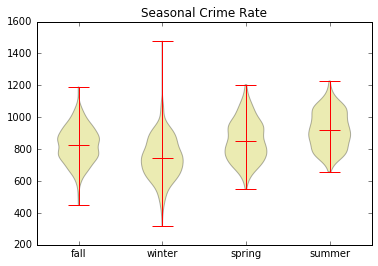

In [294]:
seasons = ["fall", "winter", "spring", "summer"]
data = combined.groupby("Season")["Date"].value_counts()
ax = plt.figure().add_subplot(111)

plt.violinplot([data[s] for s in seasons], range(len(seasons)), showmeans= True)
ax.set_xticks(range(len(seasons)))
ax.set_xticklabels(seasons)
ax.set_title("Seasonal Crime Rate")

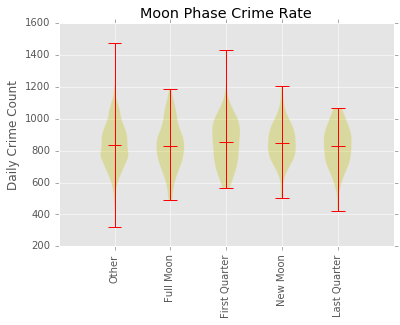

In [302]:
# help on violin labeling from http://matplotlib.org/examples/statistics/violinplot_demo.html
phases = combined.MoonPhase.unique()
data = combined.groupby("MoonPhase")["Date"].value_counts()
ax = plt.figure().add_subplot(111)

plt.violinplot([data[s] for s in phases], range(len(phases)), showmeans= True)
ax.set_xticks(range(len(phases)))
ax.set_xticklabels(phases, rotation=90)
ax.set_ylabel("Daily Crime Count")
ax.set_title("Moon Phase Crime Rate")

# SCOTT - the next 5 I used for analysis but I think only one of the graphs made it into the final report. Up to you how much is transfered to the final notebook.

In [266]:
# legend help from http://stackoverflow.com/questions/23556153/how-to-put-legend-outside-the-plot-with-pandas
def season_ave_crime(bucket, grp_bucket, bucket_label = None, grp_bucket_label = None):
    crimes = combined.groupby(grp_bucket)[bucket].value_counts()
    days = combined.groupby([grp_bucket, bucket])["Date"].nunique()
    season_crime_df = crimes / days

    for s in ["fall", "winter", "spring", "summer"]:
        plot_fig= season_crime_df[s].plot(legend=True, label=s)

    plot_fig.set_xlabel(bucket_label)
    plot_fig.set_ylabel("Average Crime Rate")
    plot_fig.set_title(grp_bucket_label)
    
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
def ungrp_ave_crime(bucket, bucket_label = None, title=None):
    crimes = combined[bucket].value_counts()
    days = combined.groupby(bucket)["Date"].nunique()
    season_crime_df = crimes / days
    plot_fig = season_crime_df.plot()

    plot_fig.set_xlabel(bucket_label)
    plot_fig.set_ylabel("Average Crime Rate")
    plot_fig.set_title(title)

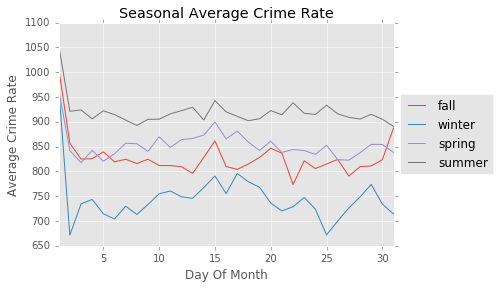

In [303]:
season_ave_crime("day", "Season", "Day Of Month", "Seasonal Average Crime Rate")

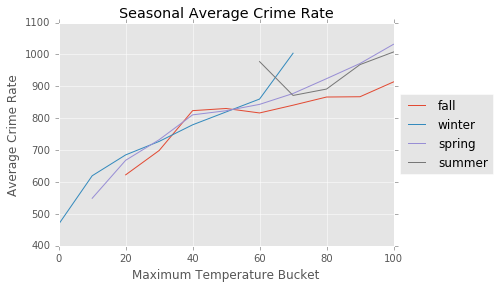

In [304]:
season_ave_crime("MaxTempBucket", "Season", "Maximum Temperature Bucket", "Seasonal Average Crime Rate")

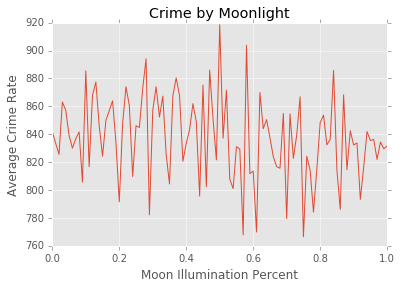

In [305]:
ungrp_ave_crime("LightPercent", "Moon Illumination Percent", title="Crime by Moonlight")

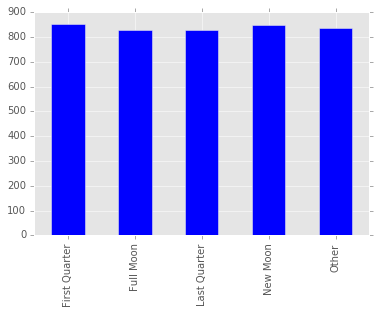

In [306]:
crimes = combined["MoonPhase"].value_counts()
days = combined.groupby("MoonPhase")["Date"].nunique()
crime_df = crimes / days
plot_fig = crime_df.plot(kind="bar", title="")

In [311]:
combined.groupby("MoonPhase")["Date"].value_counts().describe()

count    1826.000000
mean      836.842826
std       139.200452
min       319.000000
25%       743.250000
50%       833.000000
75%       931.750000
max      1477.000000
dtype: float64

In [173]:
season, temp = days.index.levels
seasonal_crime = pd.DataFrame(columns = days.index.levels)
for s in season:
    for t in temp:
        seasonal_crime[] = 

Season,fall,spring,summer,winter
MaxTempBucket,,,,
0,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN


# 6) Is crime less likely to occur on holidays?

In [155]:
# Jay
? plt.plot()

# 7) How has the crime rate changed over time? Is the change the same across all crime types?

In [ ]:
# Jay

# 8) Does the day of the month effect crime rate?

In [ ]:
# Scott

# Sandbox
## Any other useful/relevant/interesting findings?

In [ ]:
# Everybody!